<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Notebook_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup 

In [1]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('darkgrid')

# Load data

In [2]:
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


### Spot data

In [3]:
# Filter data
spot = raw_data[raw_data['CODNEG'] == 'VALE3']

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S',
    'VOLTOT': 'volume'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot = spot[spot['date'] < '01-01-2020']
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S,volume
date,,
2015-01-02,21.28,120672152.0
2015-01-05,20.96,173776434.0
2015-01-06,21.80,212788714.0
2015-01-07,22.60,135618045.0
2015-01-08,22.84,104941063.0


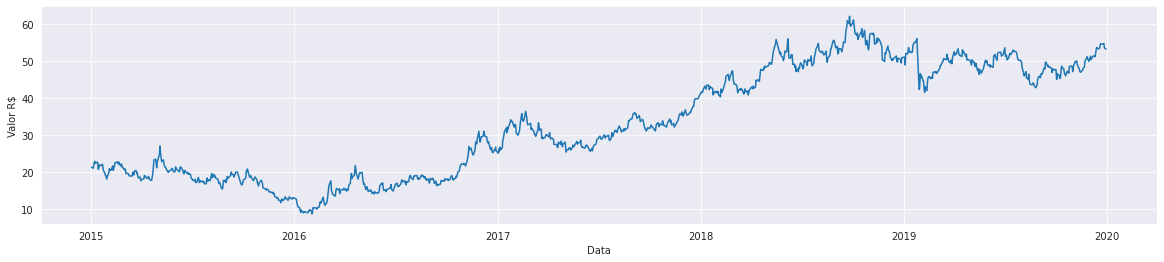

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['S'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## Options

In [5]:
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith('VALE')]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace types
option['option_type'] = option['option_type'].replace(TPMERC)

workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Filter dates
option = option[(option['date'] < '01-01-2020') &
                (option['expire'] > '2015-01-19') &
                (option['expire'] <= '2019-12-16')]

option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,VALED16,3.41,16.35,2015-04-20,call,0.289683
2015-01-02,VALEC76,0.13,23.85,2015-03-16,call,0.194444
2015-01-02,VALEC52,0.19,22.85,2015-03-16,call,0.194444
2015-01-02,VALEC51,0.36,21.85,2015-03-16,call,0.194444
2015-01-02,VALEC26,0.05,25.35,2015-03-16,call,0.194444


In [10]:
option[['option', 'T']].groupby(['option']).agg({'T': 'count'}).sort_values(by='T')

,T
option,
VALEX99,1
VALET391,1
VALEK305,1
VALEK373,1
VALEX39,1
...,...
VALEG19,161
VALEE23,163
VALEG18,167


In [13]:
option[option['option'] == 'VALEG19']

,option,value,X,expire,option_type,T
date,,,,,,
2015-02-09,VALEG19,1.54,19.11,2015-07-20,call,0.428571
2015-02-12,VALEG19,1.90,19.11,2015-07-20,call,0.416667
2015-02-20,VALEG19,2.25,19.11,2015-07-20,call,0.400794
2015-03-10,VALEG19,0.75,19.11,2015-07-20,call,0.353175
2015-03-12,VALEG19,0.60,19.11,2015-07-20,call,0.345238
...,...,...,...,...,...,...
2017-07-10,VALEG19,0.92,26.97,2017-07-17,call,0.019841
2017-07-11,VALEG19,1.20,26.97,2017-07-17,call,0.015873
2017-07-12,VALEG19,1.19,26.97,2017-07-17,call,0.011905


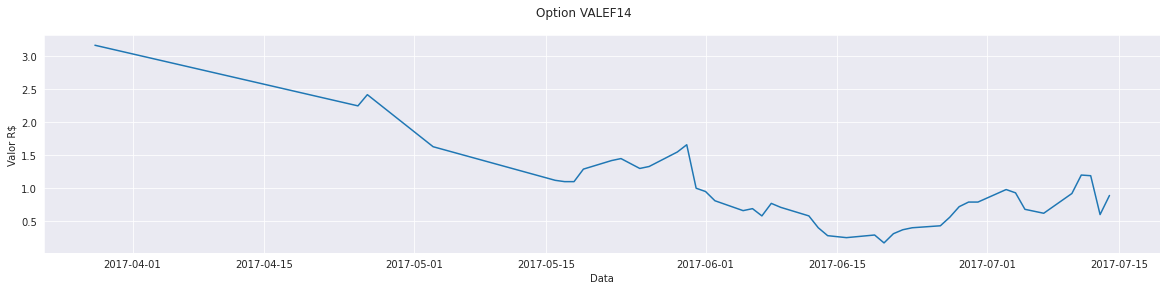

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option VALEG19')
ax.plot(option.loc[(option['option'] == 'VALEG19') & (option['expire'] == '2017-07-17'), 'value'])
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
plt.show()

## CDI

In [15]:
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

# # Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

In [16]:
# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

In [17]:
# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi = cdi[cdi['date'] < '01-01-2020']
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


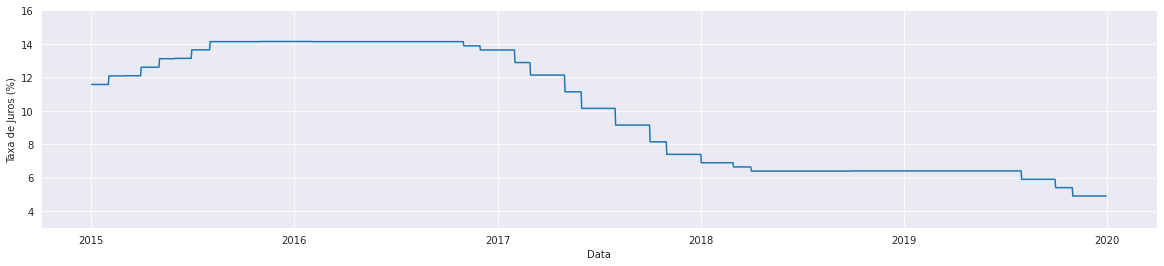

In [18]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(cdi)
ax.set_ylabel('Taxa de Juros (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Data')
plt.show()

## Data Merge

In [19]:
# Merge data
data = option.merge(right=spot, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data.head()

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,VALED16,3.41,16.35,2015-04-20,call,0.289683,21.28,120672152.0,11.57
2015-01-02,VALEC76,0.13,23.85,2015-03-16,call,0.194444,21.28,120672152.0,11.57
2015-01-02,VALEC52,0.19,22.85,2015-03-16,call,0.194444,21.28,120672152.0,11.57
2015-01-02,VALEC51,0.36,21.85,2015-03-16,call,0.194444,21.28,120672152.0,11.57
2015-01-02,VALEC26,0.05,25.35,2015-03-16,call,0.194444,21.28,120672152.0,11.57


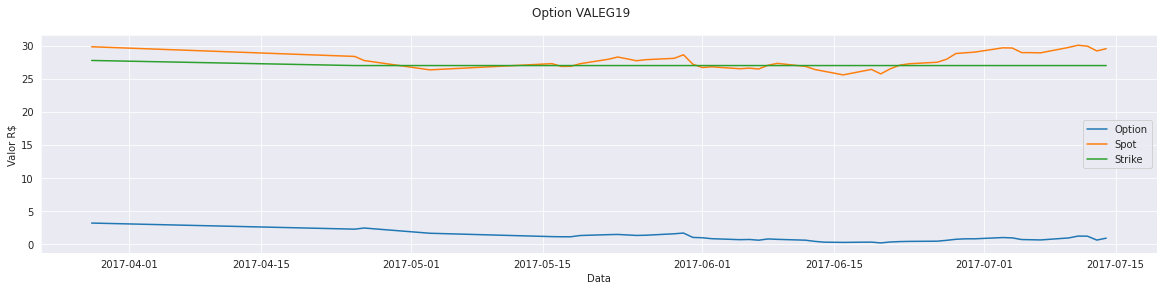

In [20]:
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option VALEG19')
ax.plot(data.loc[(option['option'] == 'VALEG19') & (option['expire'] == '2017-07-17'), 'value'], label='Option')
ax.plot(data.loc[(option['option'] == 'VALEG19') & (option['expire'] == '2017-07-17'), 'S'], label='Spot')
ax.plot(data.loc[(option['option'] == 'VALEG19') & (option['expire'] == '2017-07-17'), 'X'], label='Strike')
ax.set_ylabel('Valor R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

In [21]:
data

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,VALED16,3.41,16.35,2015-04-20,call,0.289683,21.28,1.206722e+08,11.57
2015-01-02,VALEC76,0.13,23.85,2015-03-16,call,0.194444,21.28,1.206722e+08,11.57
2015-01-02,VALEC52,0.19,22.85,2015-03-16,call,0.194444,21.28,1.206722e+08,11.57
2015-01-02,VALEC51,0.36,21.85,2015-03-16,call,0.194444,21.28,1.206722e+08,11.57
2015-01-02,VALEC26,0.05,25.35,2015-03-16,call,0.194444,21.28,1.206722e+08,11.57
...,...,...,...,...,...,...,...,...,...
2019-12-13,VALEX465,0.01,46.55,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90
2019-12-13,VALEX580,4.67,58.05,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90
2019-12-13,VALEX480,0.01,48.05,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90


# GARCH (1,1)

In [22]:
!pip install arch

     |████████████████████████████████| 798kB 2.8MB/s 


## Returns
Retornos Diários = $\ln\left(\dfrac{S_{i}}{S_{i-1}}\right) \cong  \left(\dfrac{S_{i} - S_{i-1}}{S_{i-1}}\right)$ 


Variância =  $\sigma^{2}_{n} = \dfrac{1}{m} \sum^{m}_{i=1} u_{n}^2$

In [23]:
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot['var'] = spot['return']**2
spot.head()

,S,volume,return,var
date,,,,
2015-01-05,20.96,173776434.0,-0.015152,0.000230
2015-01-06,21.80,212788714.0,0.039294,0.001544
2015-01-07,22.60,135618045.0,0.036040,0.001299
2015-01-08,22.84,104941063.0,0.010563,0.000112
2015-01-09,22.35,80426260.0,-0.021687,0.000470


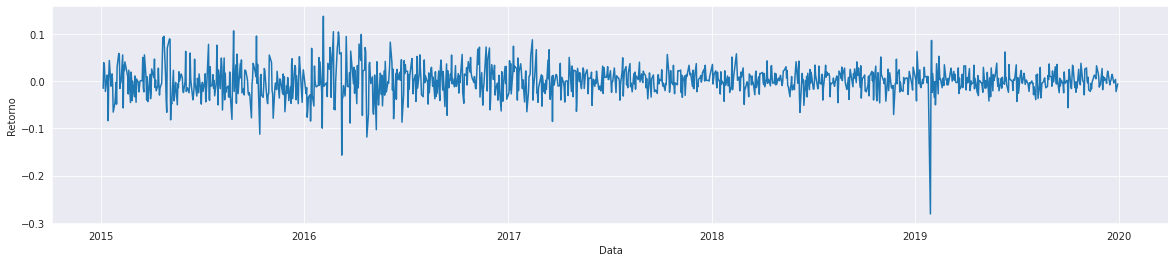

In [24]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(spot['return'])
ax.set_ylabel('Retorno')
ax.set_xlabel('Data')
plt.show()

## GARCH (with a Constant Mean)

In [25]:
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: -2615.3345754043685
Iteration:     10,   Func. Count:     83,   Neg. LLF: -2616.5329632350813
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2616.5402333216234
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2616.54
Distribution:                  Normal   AIC:                          -5225.08
Method:            Maximum Likelihood   BIC:                          -5204.61
                                        No. Observations:                 1233
Date:                Tue, Oct 27 2020   Df Residuals:                     1229
Time:  

### Plot

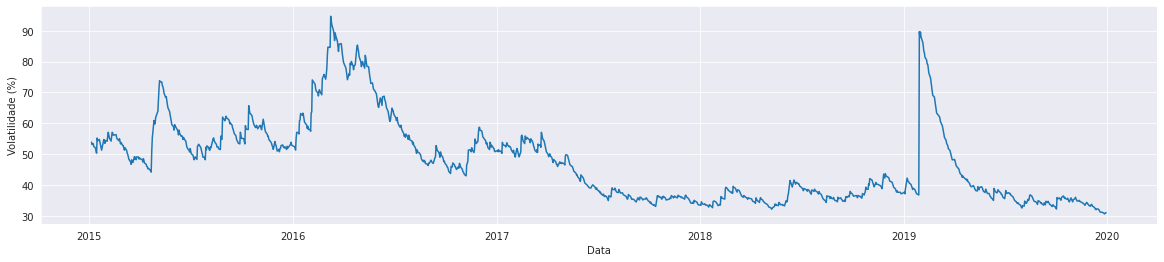

In [26]:
fig, axs = plt.subplots(figsize=(20, 4))
axs.plot(garch)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

In [27]:
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,VALEC17,2.11,17.35,2015-03-16,call,0.190476,20.96,173776434.0,11.57,53.907341
2015-01-05,VALEC78,0.04,24.85,2015-03-16,call,0.190476,20.96,173776434.0,11.57,53.907341
2015-01-05,VALEC77,0.06,24.35,2015-03-16,call,0.190476,20.96,173776434.0,11.57,53.907341
2015-01-05,VALEC76,0.08,23.85,2015-03-16,call,0.190476,20.96,173776434.0,11.57,53.907341
2015-01-05,VALEC51,0.29,21.85,2015-03-16,call,0.190476,20.96,173776434.0,11.57,53.907341


In [28]:
cols = ['option', 'S', 'X', 'T', 'r', 'sigma', 'option_type', 'value']
data.to_csv('/content/drive/My Drive/Datasets/data_option.csv')

In [29]:
data[data['option_type'] == 'put']

,option,value,X,expire,option_type,T,S,volume,r,sigma
date,,,,,,,,,,
2015-01-05,VALEO19,1.50,19.35,2015-03-16,put,0.190476,20.96,1.737764e+08,11.57,53.907341
2015-01-05,VALEO18,0.93,18.35,2015-03-16,put,0.190476,20.96,1.737764e+08,11.57,53.907341
2015-01-05,VALEN83,2.23,20.85,2015-02-09,put,0.099206,20.96,1.737764e+08,11.57,53.907341
2015-01-05,VALEN81,0.95,18.85,2015-02-09,put,0.099206,20.96,1.737764e+08,11.57,53.907341
2015-01-05,VALEN80,0.49,17.85,2015-02-09,put,0.099206,20.96,1.737764e+08,11.57,53.907341
...,...,...,...,...,...,...,...,...,...,...
2019-12-13,VALEX465,0.01,46.55,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90,32.283598
2019-12-13,VALEX580,4.67,58.05,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90,32.283598
2019-12-13,VALEX480,0.01,48.05,2019-12-16,put,0.003968,53.76,1.506382e+09,4.90,32.283598
